## Distribution of Fundamental Processes

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.integrate import quad
import time
import numpy as np
from scipy.integrate import quad_vec
import scipy.stats as si
import pygad
import torch
from tqdm import tqdm
import random
from scipy.optimize import minimize, differential_evolution
from scipy.ndimage import uniform_filter1d
from scipy.interpolate import UnivariateSpline
from matplotlib.patches import Ellipse
from scipy.stats import gaussian_kde



In [34]:
# Enable LaTeX fonts in plots
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "axes.labelsize": 12,
    "font.size": 12,
    "legend.fontsize": 12,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
})

In [ ]:
# Seeds
MASTER_SEED = 42
np.random.seed(MASTER_SEED)
random.seed(MASTER_SEED)

In [ ]:
#Parameters

#Simulation parameters
T = 1.0         # Time horizon (years)
N = 252         # Number of time steps (daily steps for 1 year)
dt = T / N      # Time increment
M = 10000       # Number of Monte Carlo simulations

#Interest rate parameters
kappa_r= 0.13                                       # Speed of mean reversion                                               # Escobar
varphi_r=0.0025                                     # Varphi_r/kappa_r is the long term mean of the interest rate           # Escobar
print("varphi_r/kappa_r: ", varphi_r / kappa_r)     # Varphi_r/kappa_r is the long term mean of the interest rate           # Escobar
sigma_r= 0.0566                                     # Volatility of the interest rate                                       # 5 pct. Escobar
r0 = varphi_r / kappa_r                             # Initial interest rate                                                 # 2 pct. Escobar

#Bond parameters
lambda_r = -0.1132                  # Market price of risk                                                                  # Escobar
T_tilde = T                         # Bond maturity

#Stock and variance 

# Parameters for Heston volatility process
kappa_v = 2.8278                                    # Speed of mean reversion for variance                                                          # Escobar
varphi_v= 0.0563                                    # varphi_v/kappa_v is the long-run variance level set to 0.13**2 as per Liu and Pan 2003        # Escobar
print("varphi_v/kappa_v: ", varphi_v / kappa_v)     # Varphi_r/kappa_r is the long term mean of the interest rate                                   # Escobar
sigma_v = 0.2941                                    # Volatility of variance process                                                                # Escobar
V0 = varphi_v / kappa_v                             # Initial variance                                                                              # Escobar    
rho = -0.23                                         # Correlation between stock and variance                                                        # Escobar                                  
lambda_v= -6.6932                                   # Risk premium on variance                                                                      # Escobar                 

# Parameters for stock price process
S0 = 100                    # Initial stock price                                                                                                   # Escobar
lambda_s = 2.2472           # Risk premium on stock                                                                                                 # Escobar                        
nu=-0.5973                  # Correlation parameter stock and bond                                                                                  # Escobar 
lambda_j = 0.2              # Jump amplitude, >0 (see code above for jump process)                                                                  # Derived from Liu and Pan 
lambda_j_q = 0.4            # Risk premium for jump risk                                                                                            # 3.5% per year estimated in Pan 2002
mu= -0.25                   # Stock price jumps, constant multiple >-1 (in pct.)                                                                    # Liu and Pan

# Parameters for jump process
lambda_J = 0.5                # Jump frequency (per year)                                                                                     # Liu and Pan

# Parameters for option pricing 
num_K= 9
device = "cuda" if torch.cuda.is_available() else "cpu"
sqrt_dt = torch.sqrt(torch.tensor(dt)).to(device)
sqrt_1_minus_rho2 = torch.sqrt(torch.tensor(1 - rho**2, device=device))
S0_val = S0
V0_val = V0
r0_val = r0
mu_val = mu

# Parameters for optimization 
gamma= 3
num_options= 5

#Sensitivity parameters
vals = 10 # Number of values for the sensitivity analysis
num_runs = 10  # Number of runs of GA per sensitivity analysis


varphi_r/kappa_r:  0.019230769230769232
varphi_v/kappa_v:  0.019909470259565742


In [37]:
# Function for b(T-t)
def b_func(T_tilde, t, kappa_r, lambda_r):
    xi = np.sqrt((kappa_r + lambda_r) ** 2 + 2 * sigma_r ** 2)
    num = 2 * (np.exp(xi * (T_tilde - t)) - 1)
    den = 2 * xi + (xi + kappa_r + lambda_r) * (np.exp(xi * (T_tilde - t)) - 1)
    return num / den

In [38]:
print("Return on stock: ", r0+lambda_v*rho*V0+lambda_s*np.sqrt(1-rho**2)*V0+nu*lambda_r*r0+mu*(lambda_j-lambda_j_q)*V0)
print("Return on bond: ", r0-lambda_r*b_func(1,0,kappa_r,lambda_r)*r0)

Return on stock:  0.09571696940100512
Return on bond:  0.021388365884807477


In [ ]:
# Result arrays
call_prices = np.zeros((M, N + 1, num_K))
put_prices = np.zeros((M, N + 1, num_K))
delta_call = np.zeros((M, N + 1, num_K))
delta_put = np.zeros((M, N + 1, num_K))
vega_call = np.zeros((M, N + 1, num_K))
vega_put = np.zeros((M, N + 1, num_K))
rho_call = np.zeros((M, N + 1, num_K))
rho_put = np.zeros((M, N + 1, num_K))
jump_call = np.zeros((M, N + 1, num_K))
jump_put = np.zeros((M, N + 1, num_K))

# Paths
S_paths = np.zeros((M, N + 1))
V_paths = np.zeros((M, N + 1))
r_paths = np.zeros((M, N + 1))
N_J = np.random.poisson(lambda_J * dt, size=(M, N + 1)) 
B= np.zeros((M, N + 1))
M_t= np.zeros((M, N + 1))
dW_r = np.random.normal(0, np.sqrt(dt), size=(M, N + 1))
dW_v = np.random.normal(0, np.sqrt(dt), size=(M, N + 1))
dW_s = np.random.normal(0, np.sqrt(dt), size=(M, N + 1))


def simulation(S_t, V_t, r_t, rho, nu, lambda_v):
    S_paths[:, 0] = S_t
    V_paths[:, 0] = V_t
    r_paths[:, 0] = r_t
    B[:, 0] = 1
    M_t[:, 0] = 1

    for j in range(1, N + 1):
        S_prev = S_paths[:, j - 1]
        V_prev = V_paths[:, j - 1]
        r_prev = r_paths[:, j - 1]

        # CIR
        r_new = r_prev + (varphi_r - kappa_r * r_prev) * dt + sigma_r * np.sqrt(np.maximum(r_prev, 0)) * dW_r[:, j]
        r_new = np.maximum(r_new, 0)

        # Heston
        V_new = V_prev + (varphi_v - kappa_v * V_prev) * dt + sigma_v * np.sqrt(np.maximum(V_prev, 0)) * dW_v[:, j]
        V_new = np.maximum(V_new, 0)

        # Stock Diffusion
        diffusion = np.sqrt(V_prev) * (rho * dW_v[:, j] + np.sqrt(1 - rho**2) * dW_s[:, j]) * S_prev+ nu*sigma_r*np.sqrt(r_prev)*dW_r[:, j]*S_prev
        
        # Jump Term
        jump_term = S_prev * mu * (N_J[:, j]- lambda_j * V_prev * dt)
        
        # Stock Drift
        drift = (r_prev+lambda_v*rho*V_prev+lambda_s*np.sqrt(1 - rho**2)*V_prev+nu*lambda_r*r_prev+mu*(lambda_j-lambda_j_q)*V_prev) * S_prev * dt

        # Stock Process
        S_new = S_prev + drift + diffusion + jump_term

        # Money Market
        M_t[:, j] = M_t[:, j - 1] * np.exp(r_prev * dt)


        # Bond Process
        t_curr= j *dt
        b_T_t = b_func(T_tilde, t_curr, kappa_r, lambda_r)
        drift_B = (r_prev - lambda_r * b_T_t*r_prev) * B[:, j - 1] * dt
        diffusion_B =  -b_T_t * sigma_r * np.sqrt(r_prev) * B[:, j - 1] * dW_r[:, j]
        B[:, j] = B[:, j - 1] + drift_B + diffusion_B

        S_paths[:, j] = S_new
        V_paths[:, j] = V_new
        r_paths[:, j] = r_new

    return S_paths, V_paths, r_paths

simulation(S0, V0, r0, rho, nu, lambda_v)

def simulate_bumped_V_local(S_curr, V_curr, r_curr, N_Jump, dW_v, dW_s, dW_r, epsilon, rho, nu):
    V_bumped = np.maximum(V_curr + epsilon, 0)
    jump_term = S_curr * mu * (N_Jump - lambda_j * V_bumped * dt)
    drift = (r_curr + lambda_v * rho * V_bumped + lambda_s * np.sqrt(1 - rho**2) * V_bumped +
             nu * lambda_r * r_curr + mu * (lambda_j - lambda_j_q) * V_bumped) * S_curr * dt
    diffusion = (np.sqrt(V_bumped) * (rho * dW_v + np.sqrt(1 - rho**2) * dW_s) +
                 nu * sigma_r * np.sqrt(r_curr) * dW_r) * S_curr
    return S_curr + drift + diffusion + jump_term

def simulate_bumped_r_local(S_curr, V_curr, r_curr, N_Jump, dW_v, dW_s, dW_r, epsilon, rho, nu):
    r_bumped = np.maximum(r_curr + epsilon, 0)
    jump_term = S_curr * mu * (N_Jump - lambda_j * V_curr * dt)
    drift = (r_bumped + lambda_v * rho * V_curr + lambda_s * np.sqrt(1 - rho**2) * V_curr +
             nu * lambda_r * r_bumped + mu * (lambda_j - lambda_j_q) * V_curr) * S_curr * dt
    diffusion = (np.sqrt(V_curr) * (rho * dW_v + np.sqrt(1 - rho**2) * dW_s) +
                 nu * sigma_r * np.sqrt(r_bumped) * dW_r) * S_curr
    return S_curr + drift + diffusion + jump_term

def numerical_option_pricing(S, K):
    return max(S - K, 0), max(K - S, 0)

epsilon_S = 1e-4
epsilon_V = 1e-3  # for Vega
epsilon_r = 1e-3  # for Rho

def prices_greeks(rho, nu):

    for i in tqdm(range(M), desc="Simulating Monte Carlo Paths"):
        for j in range(N + 1):
            S_mean = np.mean(S_paths[:, j])
            S_curr = S_paths[i, j]
            strike_prices = np.linspace(S_mean * 0.8, S_mean * 1.2, num_K)
            S_bump_S_up = S_curr + epsilon_S
            S_bump_S_down = S_curr - epsilon_S
            S_bump_jump = S_curr * (1 + mu)

            S_bumped_V = simulate_bumped_V_local(S_curr, V_paths[i, j], r_paths[i, j], N_J[i, j], dW_v[i, j], dW_s[i, j], dW_r[i, j], epsilon_V, rho, nu)
            S_bumped_r = simulate_bumped_r_local(S_curr, V_paths[i, j], r_paths[i, j], N_J[i, j], dW_v[i, j], dW_s[i, j], dW_r[i, j], epsilon_r, rho, nu)

            for k, K in enumerate(strike_prices):
                call, put = numerical_option_pricing(S_curr, K)
                call_prices[i, j, k] = call
                put_prices[i, j, k] = put
                call_V, put_V = numerical_option_pricing(S_bumped_V, K)
                call_r, put_r = numerical_option_pricing(S_bumped_r, K)
                call_S_up, put_S_up = numerical_option_pricing(S_bump_S_up, K)
                call_S_down, put_S_down = numerical_option_pricing(S_bump_S_down, K)
                call_J, put_J = numerical_option_pricing(S_bump_jump, K)

                delta_call[i, j, k] = (call_S_up - call_S_down) / (epsilon_S*2)
                delta_put[i, j, k] = (put_S_up - put_S_down) / (epsilon_S*2)
                vega_call[i, j, k] = (call_V - call) / epsilon_V
                vega_put[i, j, k] = (put_V - put) / epsilon_V
                rho_call[i, j, k] = (call_r - call) / epsilon_r
                rho_put[i, j, k] = (put_r - put) / epsilon_r
                jump_call[i, j, k] = (call_J - call)
                jump_put[i, j, k] = (put_J - put)

prices_greeks(rho, nu)

S=S_paths
V=V_paths
r=r_paths


Simulating Monte Carlo Paths: 100%|██████████| 10000/10000 [01:57<00:00, 85.10it/s]


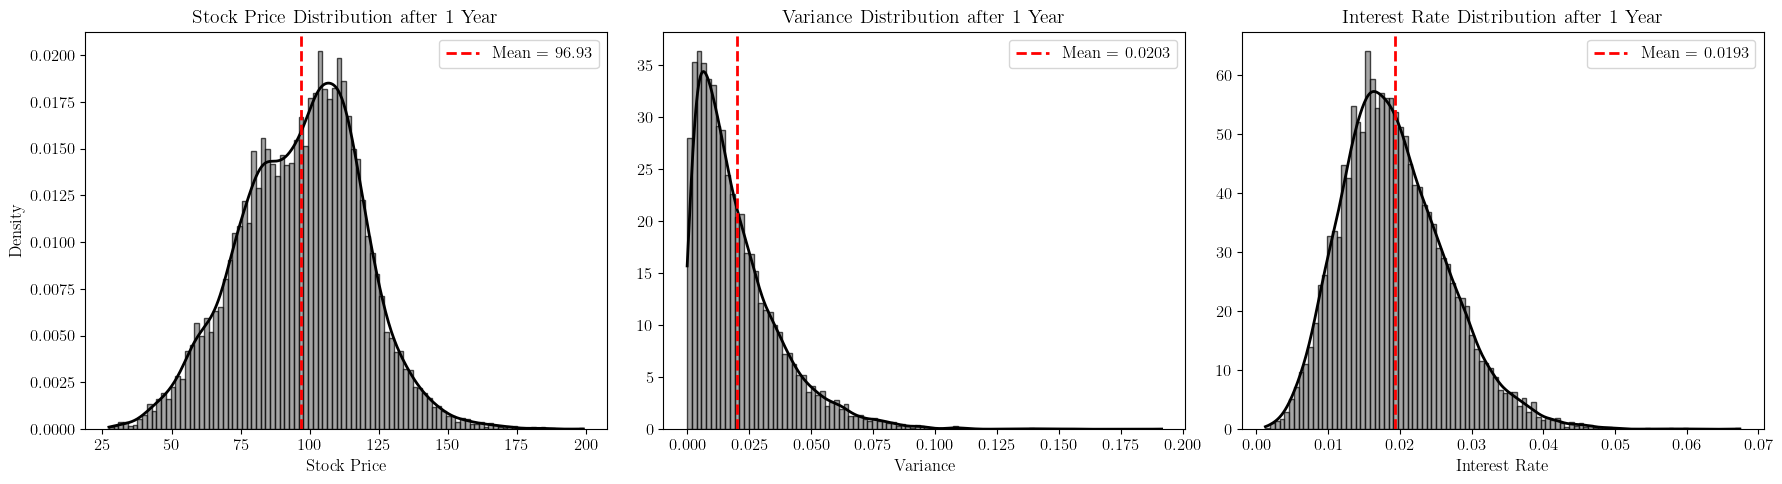

In [ ]:
S_np = S
V_np = V
r_np = r


S_T = S_np[:, -1]
V_T = V_np[:, -1]
r_T = r_np[:, -1]

fig, axs = plt.subplots(1, 3, figsize=(18, 5))

data_list = [S_T, V_T, r_T]
titles = ['Stock Price Distribution after 1 Year', 'Variance Distribution after 1 Year', 'Interest Rate Distribution after 1 Year' ]
xlabels = ['Stock Price', 'Variance', 'Interest Rate']

for i, (data, title, xlabel) in enumerate(zip(data_list, titles, xlabels)):
    axs[i].hist(data, bins=100, density=True, alpha=0.7, color='grey', edgecolor='black')

    kde = gaussian_kde(data)
    x_vals = np.linspace(data.min(), data.max(), 500)
    axs[i].plot(x_vals, kde(x_vals), color='black', linewidth=2)

    mean_val = np.mean(data)
    
    if i == 0:
        mean_text = f'Mean = {mean_val:.2f}'
    else:
        mean_text = f'Mean = {mean_val:.4f}'
    
    axs[i].axvline(mean_val, color='red', linestyle='--', linewidth=2, label=mean_text)
    
    axs[i].set_title(title, fontsize=14)
    axs[i].set_xlabel(xlabel, fontsize=12)
    if i == 0:
        axs[i].set_ylabel('Density', fontsize=12)  
    else:
        axs[i].set_ylabel('')  

    
    axs[i].legend()
    axs[i].tick_params(axis='both', labelsize=12)
    axs[i].grid(False)  

plt.tight_layout()
plt.savefig('distributions.png', dpi=600)
plt.show()


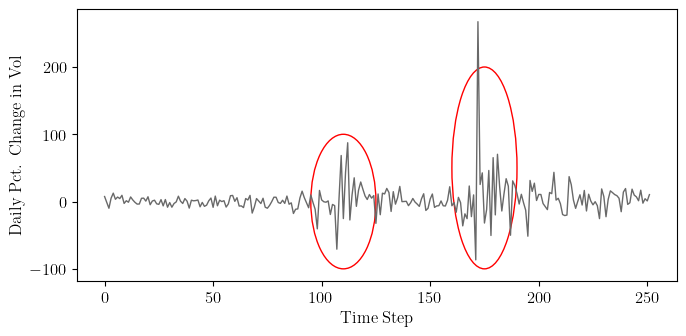

In [ ]:
eps = 1e-8
vol=np.sqrt(V_np)
vol_pct_changes = (vol[:, 1:] - vol[:, :-1]) / (vol[:, :-1] + eps)

np.random.seed(19)
sample_path_idx = np.random.randint(0, V_np.shape[0])
sample_vol_changes = vol_pct_changes[sample_path_idx]

fig, ax = plt.subplots(figsize=(7, 3.5))  # Smaller figure size (half the previous)

ax.plot(sample_vol_changes * 100, color='dimgrey', linewidth=1)  # thinner line
ax.set_xlabel('Time Step', fontsize=12)
ax.set_ylabel('Daily Pct. Change in Vol', fontsize=12)
ax.tick_params(axis='both', labelsize=12)
ax.grid(False)

circle1 = Ellipse((110, 0), width=30, height=200, edgecolor='red', facecolor='none', linewidth=1)
circle2 = Ellipse((175, 50), width=30, height=300, edgecolor='red', facecolor='none', linewidth=1)

ax.add_patch(circle1)
ax.add_patch(circle2)

plt.tight_layout(pad=1.0)
plt.savefig('volatility_clustering.png', dpi=600)
plt.show()
